# Final Project#

For the final project, I have chosen to create a machine learning model based on the 30-ICU readmissions based on the MIMIC-III database.

The MIMIC-III database is as cited below:

MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: 
http://www.nature.com/articles/sdata201635


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Overview and Background##

The project that I have chosen to investigate is in creating a machine learning model based on predicting on whether a particular patient will be readmitted within 30-days. While the basis behind this problem may not be particularly evident, there is actually a variety of reasons why predicting whether a patient will be readmitted is particularly useful.

The first of these is in terms of the financial costs to the hospital institution. The idea behind evaluating 30-day readmissions is that if a patient is sick enough to come back within 30-days of last entering the hospital, it is highly likely that they were not in a stable enough condition to be discahrged in the first place. By predicting the patients that are at high risk for readmission, it is possible to reduce the amount of unnnecessary financial burden on the hospital since readmissions are particularly draining on hospital resources.

The second problem that this would help solve would be in reducing the amount of space that are required to house these readmitted patients. When a patient is readmitted within 30 days from their discharge, they not only drain financial resources from the hospital, but can also take up necessary bed space and hospital space that could be potentially needed to treat other patients. 

In this sense, if physcians had the means to predict whether a patient were at high risk to be readmitted, they would be able to take extra measures to make sure the patients are kept in the hospital and not discharged until they are unlikely to be readmitted within a short period of time.

## Data 

### Importing Data

For the purposes of this project, I have drawn a lot of insight from the Capstone project done here: https://github.com/YaronBlinder/MIMIC-III_readmission/blob/master/Report.pdf 

Based on some of the previous work done, I determined the tables I wanted to download from the Mimic III database. The **admissions** table gives me relevant information such as Subject ID, Admission ID, Admit Time, Discharge Time, Death Time (if died during stay), Marital Status and Insurance provider. From the **patients** table, I can obtain information such Age and Gender. From the **lab events** I was able to determine the numerical values for lab tests based on their test ID and from **D_LABITEMS** I was able to find the lab test IDs for the actual tests that I am interested in (namely Calcium (Total), Albumin, Urea Nitrogen and Magnesium)

Since the **lab events** table was most likely too big to be loaded into memory of the Jupyter Notebook, I parsed out only the columns that I wanted (SUBJECT_ID, HADM_ID, ITEM_ID and VALUENUM) and then took the first 2 million rows of the data set. This was done on command line using the following commands:

*cut -d , -f 2,4-6 LABEVENTS.csv > test.csv*  
*sudo head -n 2000000 test.csv > cleaned_data.csv*

In [2]:
admissions = pd.read_csv('ADMISSIONS.csv')
labevents = pd.read_csv('cleaned_data.csv')
D_lab = pd.read_csv('D_LABITEMS.csv')
patients = pd.read_csv('PATIENTS.csv')

### Cleaning Up the Data

In the labevents csv file, there were many cases where there was no information in the HADM_ID section. These correspond with outpatients and will not be something that I will be considering. As such, the first step that I took was in removing any NaN values that existed in the HADM_ID column of the labevents dataframe.

Next, since I want to be use age as a statistic, I will calculate the patient's age based on their DOB (unless they have a DOB, in which case I will calculate their age by subtracting the DOB from the DOD). To find the patients that are still alive, since I was uncertain about how the timestamps were recorded, I decided to make the current time one year after the latest date of death and use that as the current time stamp.

To make the dataset easier to visualize, upon the calculating the age, I also removed information that was not relevant to the machine learning process.

In [3]:
labevents = labevents.dropna()
# removes all rows that have are NaN in the dataframe - in this case, only HADM_ID has NaNs

patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'])
# converts DOD and DOB to data time objects in the pd dataframe

print((patients['DOD']).max())
currentTime = pd.Timestamp(2212, 6, 10, 10, 10, 10)
# find the current time by adding one year onto the most recent date of death

patients['Age'] = ((patients['DOD'] - patients['DOB']).dt.days)/365
# for the rows that do not have NaN in the DOD column, subtract the DOB from DOD to get the age at their time of death

patients['CurrentTime'] = currentTime
patients['CurrentTime'] = pd.to_datetime(patients['CurrentTime'])

patients['Temp'] = (patients['CurrentTime'] - patients['DOB']).dt.days/365
# creates a temporary column that has the ages of the patients - including all the patients that have died

patients.loc[patients['Age'].isna(), 'Age'] = patients['Temp']
# for all the ages that are nan - i.e. the patients that do not have a DOD value -, replace it with the age calculated

patients = patients[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'Age']]

patients.head()

2211-06-10 00:00:00


,SUBJECT_ID,GENDER,DOB,DOD,Age
0,249,F,2075-03-13,NaT,137.334247
1,250,F,2164-12-27,2188-11-22,23.920548
2,251,M,2090-03-15,NaT,122.317808
3,252,M,2078-03-06,NaT,134.350685
4,253,F,2089-11-26,NaT,122.616438


I then further cleaned up, and made the **labevents** table smaller by only keeping the lab tests that I thought were relevant to the machine learning model. I got the *ITEMID* of the tests corresponding to the four categories I listed below.

Calcium (Total) - 50893   
Albumin - 50862   
Urea Nitrogen - 51006   
Magnesium - 50960


In [4]:
labevents = labevents.loc[(labevents['ITEMID'] == 50893) | (labevents['ITEMID'] == 50862) | 
                          (labevents['ITEMID']==51006) | (labevents['ITEMID'] == 50960)]
# locates and only keeps the rows that correspond to the 4 subject codes for calcium, albumin, urea and magnesium

labevents.head()

,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM
162,3,145834.0,50893,8.2
168,3,145834.0,50960,2.4
178,3,145834.0,50893,7.6
182,3,145834.0,50960,2.1
187,3,145834.0,51006,36


On top of all the other preprocessing that I am doing, one thing that will eventually be important for the machine learning portion using sklearn will be that scikit-learn only understands numeric inputs. To this end, all the important columns that I will be using in the machine learning model must be converted into numeric models. Sklearn provides a good way to do this.

In [5]:
from sklearn import preprocessing

# create the Labelencoder object
le = preprocessing.LabelEncoder()

#convert the categorical columns into numeric

admissions['INSURANCE'] = le.fit_transform(admissions['INSURANCE'])
# where 0 corresponds to Government, 1 to Medicaid, 2 to Medicare, 3 to Private and 4 to Self Pay

admissions['MARITAL_STATUS'].fillna('', inplace=True)
# fill the nan values with the empty string to allow for the transformation of the fit
# 0 corresponds to the empty string

admissions['MARITAL_STATUS'] = le.fit_transform(admissions['MARITAL_STATUS'])

patients['GENDER'] = le.fit_transform(patients['GENDER'])
# where 0 corresponds to F and 1 corresponds with M

I also want to change the ADMITTIME and DISCHTIME values into datetime values so I can utilize them later

In [6]:
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

Following this, I combined the **labevents** table with the the **D_LABITEMS** table so that I would be able to better see on the table what each of the lab tests actually was.

In [7]:
mergedLab = pd.merge(labevents, D_lab[['ITEMID', 'LABEL']], on='ITEMID')
# merges the labevents and D_lab dataframe on the column 'ITEMID', while only selecting the columns of ITEMID and LABEL from
# the D_lab dataframe

Upon inspection, I realized that the VALUENUM column actually contained string values. I will want to use the values later
as a means for doing some data visualizations so I will need to change the value column to either integer or float values.

In addition, there are certain VALUENUMs that are mislabeled and thus cannot be directly cast to floats. I removed these columns from the dataframe to account for this problem.

In [8]:
mergedLab = mergedLab.drop(mergedLab[mergedLab.VALUENUM == 'SPECIMEN MISLABELLED"'].index)

In [9]:
mergedLab.VALUENUM = mergedLab.VALUENUM.astype(float).fillna(0.0)
mergedLab.head()

,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM,LABEL
0,3,145834.0,50893,8.2,"Calcium, Total"
1,3,145834.0,50893,7.6,"Calcium, Total"
2,3,145834.0,50893,7.1,"Calcium, Total"
3,3,145834.0,50893,7.5,"Calcium, Total"
4,3,145834.0,50893,7.4,"Calcium, Total"


In preparation for the machine learning that will be done later, I actually want to separate  the 4 labels into different columns (so that each of the tests can be a different column in the *predictor*) later on. To do this, I'm going to first create 4 different data frames and then join them back into the mergedLab dataframe to replace the current **LABEL** column. In addition, for the purposes of the machine learning model, I will be looking at the average **VALUENUM** for each patient.

In [10]:
groupedLabs = mergedLab.groupby('LABEL')  

albumin = groupedLabs.get_group('Albumin')[['SUBJECT_ID','VALUENUM']]
calcium = groupedLabs.get_group('Calcium, Total')[['SUBJECT_ID','VALUENUM']]
mag = groupedLabs.get_group('Magnesium')[['SUBJECT_ID','VALUENUM']]
urea = groupedLabs.get_group('Urea Nitrogen')[['SUBJECT_ID','VALUENUM']]
# separates out the valuenum column and subject_ID

alb_mean = albumin.groupby('SUBJECT_ID', as_index=False)['VALUENUM'].mean()
calc_mean = calcium.groupby('SUBJECT_ID', as_index=False)['VALUENUM'].mean()
mag_mean = mag.groupby('SUBJECT_ID', as_index=False)['VALUENUM'].mean()
urea_mean = urea.groupby('SUBJECT_ID', as_index=False)['VALUENUM'].mean()
# gets the mean value

I then also cleaned up the **admissions** table by only picking out the important information such as subject ID, admission ID, admit time, discharge time, death time, marital status and insurance provider.

I also merged the admissions with the patient table based on the *SUBJECT_ID* column.

In [11]:
mergedAdmission = pd.merge(patients, admissions[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME',
                                                 'DISCHTIME', 'DEATHTIME', 'INSURANCE', 'MARITAL_STATUS']], on='SUBJECT_ID')

# merges the patients the admissions table together based on the column of 'SUBJECT_ID'
mergedAdmission.head()

,SUBJECT_ID,GENDER,DOB,DOD,Age,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,INSURANCE,MARITAL_STATUS
0,249,0,2075-03-13,NaT,137.334247,321,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,NaN,2,1
1,249,0,2075-03-13,NaT,137.334247,322,149546,2155-02-03 20:16:00,2155-02-14 11:15:00,NaN,2,1
2,249,0,2075-03-13,NaT,137.334247,323,158975,2156-04-27 15:33:00,2156-05-14 15:30:00,NaN,2,1
3,250,0,2164-12-27,2188-11-22,23.920548,324,124271,2188-11-12 09:22:00,2188-11-22 12:00:00,2188-11-22 12:00:00,4,5
4,251,1,2090-03-15,NaT,122.317808,325,117937,2110-07-27 06:46:00,2110-07-29 15:23:00,NaN,3,0


At this point, I have cleaned up the data to the extent that I want and will move on to exploring the data better and understanding the general trends of the data.

I want to join the albumin, magnesium, calcium, and urea mean into the admissions table to create the complete data set that will be put into my machine learning model. However, since there are still duplicate entries in the current table (which has data like ADMITTIME and DISCHTIME) that I will be using to harvest more information, I will do this in the Machine Learning Data Prep section.

## Machine Learning Data Prep

To be able to begin building our model, I then want to see which patients actually have experienced a 30-day admission. This will allow me to divide the training data into the *feature* variables and the *target* variables.

The *feature* variables will be all the variables that will be used as the inputs, predictors and attributes that will be used to predict the eventual outcome.

Meanwhile, the *target* variables are the output variables that depend on the feature variables.

For this, I'll need three columns from the merged dataset, the Subject_ID, Admit time and Discharge Time, which I will separate from the rest of the data set to make the memory more manageable. 

In [12]:
subset = mergedAdmission[['SUBJECT_ID', 'ADMITTIME', 'DISCHTIME']]
subset.shape

(58976, 3)

In [13]:
subset.head()

,SUBJECT_ID,ADMITTIME,DISCHTIME
0,249,2149-12-17 20:41:00,2149-12-31 14:55:00
1,249,2155-02-03 20:16:00,2155-02-14 11:15:00
2,249,2156-04-27 15:33:00,2156-05-14 15:30:00
3,250,2188-11-12 09:22:00,2188-11-22 12:00:00
4,251,2110-07-27 06:46:00,2110-07-29 15:23:00


I first grouped the subsetted data by the **SUBJECT_ID** and got rid of any element that only occurred once - this is due to the fact that a patient could not have been readmitted into the hospital if they were only admitted once.

I then shifted down the **DISCHTIME** column so that a direct subtraction can be done to find the number of days in between readmission.

In [14]:
subset = subset[subset.groupby('SUBJECT_ID').SUBJECT_ID.transform(len) > 1]
# groups the subsetted data by the Subject_ID and gets rid of any element that only occurs once - 
# because patient cannot have been readmitted if they were only admitted once

subset['DISCHTIME'] = subset['DISCHTIME'].shift(1)
# shifts the discharge time down one so a direct subtract can be done to find the number of days between readmission

subset['Readmission_Time'] = (subset['ADMITTIME'] - subset['DISCHTIME']).dt.days
# does the subtraction

subset.head()

,SUBJECT_ID,ADMITTIME,DISCHTIME,Readmission_Time
0,249,2149-12-17 20:41:00,NaT,NaN
1,249,2155-02-03 20:16:00,2149-12-31 14:55:00,1860.0
2,249,2156-04-27 15:33:00,2155-02-14 11:15:00,438.0
5,252,2133-03-31 04:24:00,2156-05-14 15:30:00,-8446.0
6,252,2133-08-15 04:23:00,2133-04-23 15:00:00,113.0


The nature of the dataset that I created made it so that since I shifted the **DISCHTIME** down by one, the first element of every unique **SUBJECT_ID** actually corresponded to the ***next*** patient (since the **DISCHTIME** will be matched up with the **ADMITTIME** the next patient. Thus, I removed all first occurrences of a unique **SUBJECT_ID**

In [15]:
test = subset.groupby('SUBJECT_ID').apply(lambda group: group.iloc[1:, 1:])
# the nature of the dataset that I created made it so that since I shifted the DISCHTIME down by one, 
# the first element of every unique subject_id

test.head(10)

ADMITTIME           DISCHTIME  Readmission_Time
SUBJECT_ID                                                              
17         312 2135-05-09 14:11:00 2134-12-31 16:05:00             128.0
21         317 2135-01-30 20:50:00 2134-09-24 16:15:00             128.0
23         320 2157-10-18 19:34:00 2153-09-08 19:10:00            1501.0
34         331 2191-02-23 05:23:00 2186-07-20 16:00:00            1678.0
36         334 2131-05-12 19:49:00 2131-05-08 14:00:00               4.0
           335 2134-05-10 11:30:00 2131-05-25 13:30:00            1080.0
61         358 2119-01-04 18:12:00 2118-07-20 12:30:00             168.0
67         365 2157-12-02 00:45:00 2155-03-06 15:00:00            1001.0
68         367 2174-01-04 22:21:00 2174-01-03 18:30:00               1.0
84         383 2196-04-14 04:02:00 2196-02-04 17:48:00              69.0

Following this, I queried only for the values in the patient time that was greater than 0 and less than 30 to figure out which subjects had a 30-day readmissions.

In [16]:
test = test.loc[(test['Readmission_Time'] >= 0) & (test['Readmission_Time'] < 30)]

test.head()

,,ADMITTIME,DISCHTIME,Readmission_Time
SUBJECT_ID,,,,
36,334,2131-05-12 19:49:00,2131-05-08 14:00:00,4.0
68,367,2174-01-04 22:21:00,2174-01-03 18:30:00,1.0
103,404,2144-08-30 23:09:00,2144-08-20 11:15:00,10.0
105,407,2189-02-21 01:45:00,2189-02-02 16:40:00,18.0
109,416,2140-02-02 02:13:00,2140-01-21 13:25:00,11.0


In [17]:
readmitList = test.index.remove_unused_levels().tolist()
# get's all the SUBJECT_IDs of patients that had a 30 day readmission

readmitList = [i[0] for i in readmitList]
# gets the first element of each tuple of the list

readmitList = list(dict.fromkeys(readmitList))
# gets rid of the duplicates

readmitList[0:5]

[36, 68, 103, 105, 109]

Stored in **readmitList** now are all the Subject_IDs that had a 30-day readmission - and will be used as the "outcome" of the machine learning model.

Since the primary purpose of some of the columns (like DOB, DOD, DISCHTIME, ADMITTIME, DEATHTIME) were to find out more important predictor factors like Age and 30-Day Readmission, I then went ahead got rid of these columns so work with a smaller data set.

In [18]:
mergedAdmission = mergedAdmission[['SUBJECT_ID', 'GENDER', 'Age', 'INSURANCE', 'MARITAL_STATUS']]
mergedAdmission.head()

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS
0,249,0,137.334247,2,1
1,249,0,137.334247,2,1
2,249,0,137.334247,2,1
3,250,0,23.920548,4,5
4,251,1,122.317808,3,0


In [19]:
#mergedLab['LABEL'] = le.fit_transform(mergedLab['LABEL'])

Since I will end up looking at patients on an individual basis and I have already gotten the information I need (namely whether the patient had ever have a 30-day readmission), I will also go ahead and remove the duplicate subjects at this point.

In [20]:
mergedAdmission.drop_duplicates(subset ="SUBJECT_ID", 
                     keep = 'first', inplace = True) 

In [21]:
mergedAdmission.head()

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS
0,249,0,137.334247,2,1
3,250,0,23.920548,4,5
4,251,1,122.317808,3,0
5,252,1,134.350685,3,5
7,253,0,122.616438,2,7


I'll now do 4 left joins with the 4 different labels to create a table with all the values that I need for the machine learning model

In [22]:
predictor = mergedAdmission.merge(alb_mean, how='left', left_on='SUBJECT_ID', right_on='SUBJECT_ID')
predictor = predictor.rename({'VALUENUM':'Albumin'}, axis=1)
predictor.head()
# merges albumin into the dataframe

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS,Albumin
0,249,0,137.334247,2,1,3.350000
1,250,0,23.920548,4,5,2.020000
2,251,1,122.317808,3,0,4.000000
3,252,1,134.350685,3,5,2.442857
4,253,0,122.616438,2,7,NaN


In [23]:
predictor = predictor.merge(calc_mean, how='left', left_on='SUBJECT_ID', right_on='SUBJECT_ID')
predictor = predictor.rename({'VALUENUM':'Calcium'}, axis=1)
predictor.head()
# merges calcium into the dataframe

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS,Albumin,Calcium
0,249,0,137.334247,2,1,3.350000,8.676596
1,250,0,23.920548,4,5,2.020000,8.316667
2,251,1,122.317808,3,0,4.000000,9.000000
3,252,1,134.350685,3,5,2.442857,7.739394
4,253,0,122.616438,2,7,NaN,8.533333


In [24]:
predictor = predictor.merge(mag_mean, how='left', left_on='SUBJECT_ID', right_on='SUBJECT_ID')
predictor = predictor.rename({'VALUENUM':'Magnesium'}, axis=1)
predictor.head()
# merges magnesium into the dataframe

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS,Albumin,Calcium,Magnesium
0,249,0,137.334247,2,1,3.350000,8.676596,2.000000
1,250,0,23.920548,4,5,2.020000,8.316667,1.871429
2,251,1,122.317808,3,0,4.000000,9.000000,1.900000
3,252,1,134.350685,3,5,2.442857,7.739394,1.748571
4,253,0,122.616438,2,7,NaN,8.533333,1.966667


In [25]:
predictor = predictor.merge(urea_mean, how='left', left_on='SUBJECT_ID', right_on='SUBJECT_ID')
predictor = predictor.rename({'VALUENUM':'Urea'}, axis=1)
predictor.head()
# merges urea into the dataframe

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS,Albumin,Calcium,Magnesium,Urea
0,249,0,137.334247,2,1,3.350000,8.676596,2.000000,28.000000
1,250,0,23.920548,4,5,2.020000,8.316667,1.871429,11.676471
2,251,1,122.317808,3,0,4.000000,9.000000,1.900000,9.500000
3,252,1,134.350685,3,5,2.442857,7.739394,1.748571,23.975000
4,253,0,122.616438,2,7,NaN,8.533333,1.966667,16.666667


The last preparatory step here is for me to include a 30 Day Readmission column (that will serve as the target in the machine learning model). To create this, I will merge it with the indices in the *readmitList* that contained the patients that were admitted within a 30 day period again.

In [26]:
temp = pd.DataFrame({'SUBJECT_ID': readmitList})
temp['30 Day Readmission'] = 1
temp.head()
# created a temporary data frame so that I can merge it into the bigger dataframe to include the 30 Day Readmission Column

,SUBJECT_ID,30 Day Readmission
0,36,1
1,68,1
2,103,1
3,105,1
4,109,1


In [27]:
predictor = predictor.merge(temp, how='left', left_on='SUBJECT_ID', right_on='SUBJECT_ID')
predictor['30 Day Readmission'].fillna(0, inplace=True)
# after merging, all values that were NaN would mean that the patients were not readmitted
predictor.head()

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS,Albumin,Calcium,Magnesium,Urea,30 Day Readmission
0,249,0,137.334247,2,1,3.350000,8.676596,2.000000,28.000000,0.0
1,250,0,23.920548,4,5,2.020000,8.316667,1.871429,11.676471,0.0
2,251,1,122.317808,3,0,4.000000,9.000000,1.900000,9.500000,0.0
3,252,1,134.350685,3,5,2.442857,7.739394,1.748571,23.975000,0.0
4,253,0,122.616438,2,7,NaN,8.533333,1.966667,16.666667,0.0


In [28]:
predictor.shape

(46520, 10)

In [29]:
predictor = predictor.dropna()

In [30]:
predictor.shape

(10837, 10)

In [31]:
predictor.head()

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS,Albumin,Calcium,Magnesium,Urea,30 Day Readmission
0,249,0,137.334247,2,1,3.350000,8.676596,2.000000,28.000000,0.0
1,250,0,23.920548,4,5,2.020000,8.316667,1.871429,11.676471,0.0
2,251,1,122.317808,3,0,4.000000,9.000000,1.900000,9.500000,0.0
3,252,1,134.350685,3,5,2.442857,7.739394,1.748571,23.975000,0.0
6,256,1,125.942466,2,3,3.066667,8.420833,2.020000,36.857143,0.0


In [32]:
predictor.loc[predictor['30 Day Readmission'] == 1].shape
# just to double check if appending the readmission actually worked
# 1008 readmissions 

(1008, 10)

One thing to note here is that after dropping all the rows that had NaN values (since the sklearn models cannot handle NaN values) I looked at the shape of the predictor to ensure that there was enough data. I had originally cropped out part of the data to account for the limitations of pandas but ended up with only 1000 values for patient data which I deemed to be insufficient. As such, I had to go back to the first steps of the project and crop a bigger part of the **LABEVENTS** CSV file to give myself and the machine learning model more data to work with. I thought a dataset of 10000 would be enough to settled on that since the Notebook also started running far slower even with just a 300 mb file to load.

## Exploratory Data Analysis

The first thing that I thought to do in this part of the project was to investigate the merged labevents dataframe that I created. Based on the four categories that I chose and their numerical values, I wanted to figure out some sort of visualization to display them and then move forwards to look at their max, min, median and mean values.

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
mergedLab['LABEL'].unique()

array(['Calcium, Total', 'Magnesium', 'Urea Nitrogen', 'Albumin'],
      dtype=object)

In [35]:
calcium = mergedLab.loc[(mergedLab['LABEL'] == 'Calcium, Total')]

calcium['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean     8.425071
50%      8.400000
max     47.700000
min      0.000000
Name: VALUENUM, dtype: float64

In [36]:
magnesium = mergedLab.loc[(mergedLab['LABEL'] == 'Magnesium')]

magnesium['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean     2.010813
50%      2.000000
max     43.500000
min      0.000000
Name: VALUENUM, dtype: float64

In [37]:
albumin = mergedLab.loc[(mergedLab['LABEL'] == 'Albumin')]

albumin['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean    2.876596
50%     2.800000
max     6.300000
min     0.900000
Name: VALUENUM, dtype: float64

In [38]:
urea = mergedLab.loc[(mergedLab['LABEL'] == 'Urea Nitrogen')]

urea['VALUENUM'].describe().transpose()[['mean', '50%', 'max', 'min']]

mean     31.201237
50%      23.000000
max     280.000000
min       0.000000
Name: VALUENUM, dtype: float64

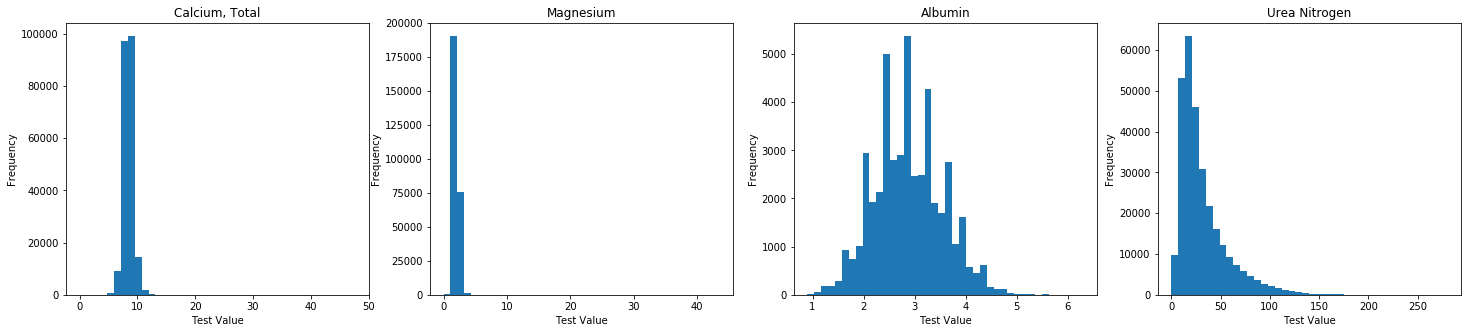

In [39]:
testNames = ['Calcium, Total', 'Magnesium', 'Albumin', 'Urea Nitrogen']

fig, axs = plt.subplots(1,4, sharex=False, sharey=False, figsize=(25,5))

index = 0
for i in range(4):
    temp = mergedLab.loc[(mergedLab['LABEL'] == testNames[i])]
    axs[i].hist(temp['VALUENUM'], 40)
    axs[i].set_title(testNames[i])
    axs[i].set_xlabel('Test Value')
    axs[i].set_ylabel('Frequency')

From the histogram visualizations, there does not appear to be a huge problem with the outliers, so processing to eliminate these outliers from the dataset was determined to be unnecessary.

One other data visualization that I think would be cool to visualize would be a scatter plot between the categories that have a wide range of values (e.g. Age, Albumin, Calcium, Magnesium and Urea) - in other words, the ones that are not defined by a small range of unique values.

In [40]:
predictor.head()

,SUBJECT_ID,GENDER,Age,INSURANCE,MARITAL_STATUS,Albumin,Calcium,Magnesium,Urea,30 Day Readmission
0,249,0,137.334247,2,1,3.350000,8.676596,2.000000,28.000000,0.0
1,250,0,23.920548,4,5,2.020000,8.316667,1.871429,11.676471,0.0
2,251,1,122.317808,3,0,4.000000,9.000000,1.900000,9.500000,0.0
3,252,1,134.350685,3,5,2.442857,7.739394,1.748571,23.975000,0.0
6,256,1,125.942466,2,3,3.066667,8.420833,2.020000,36.857143,0.0


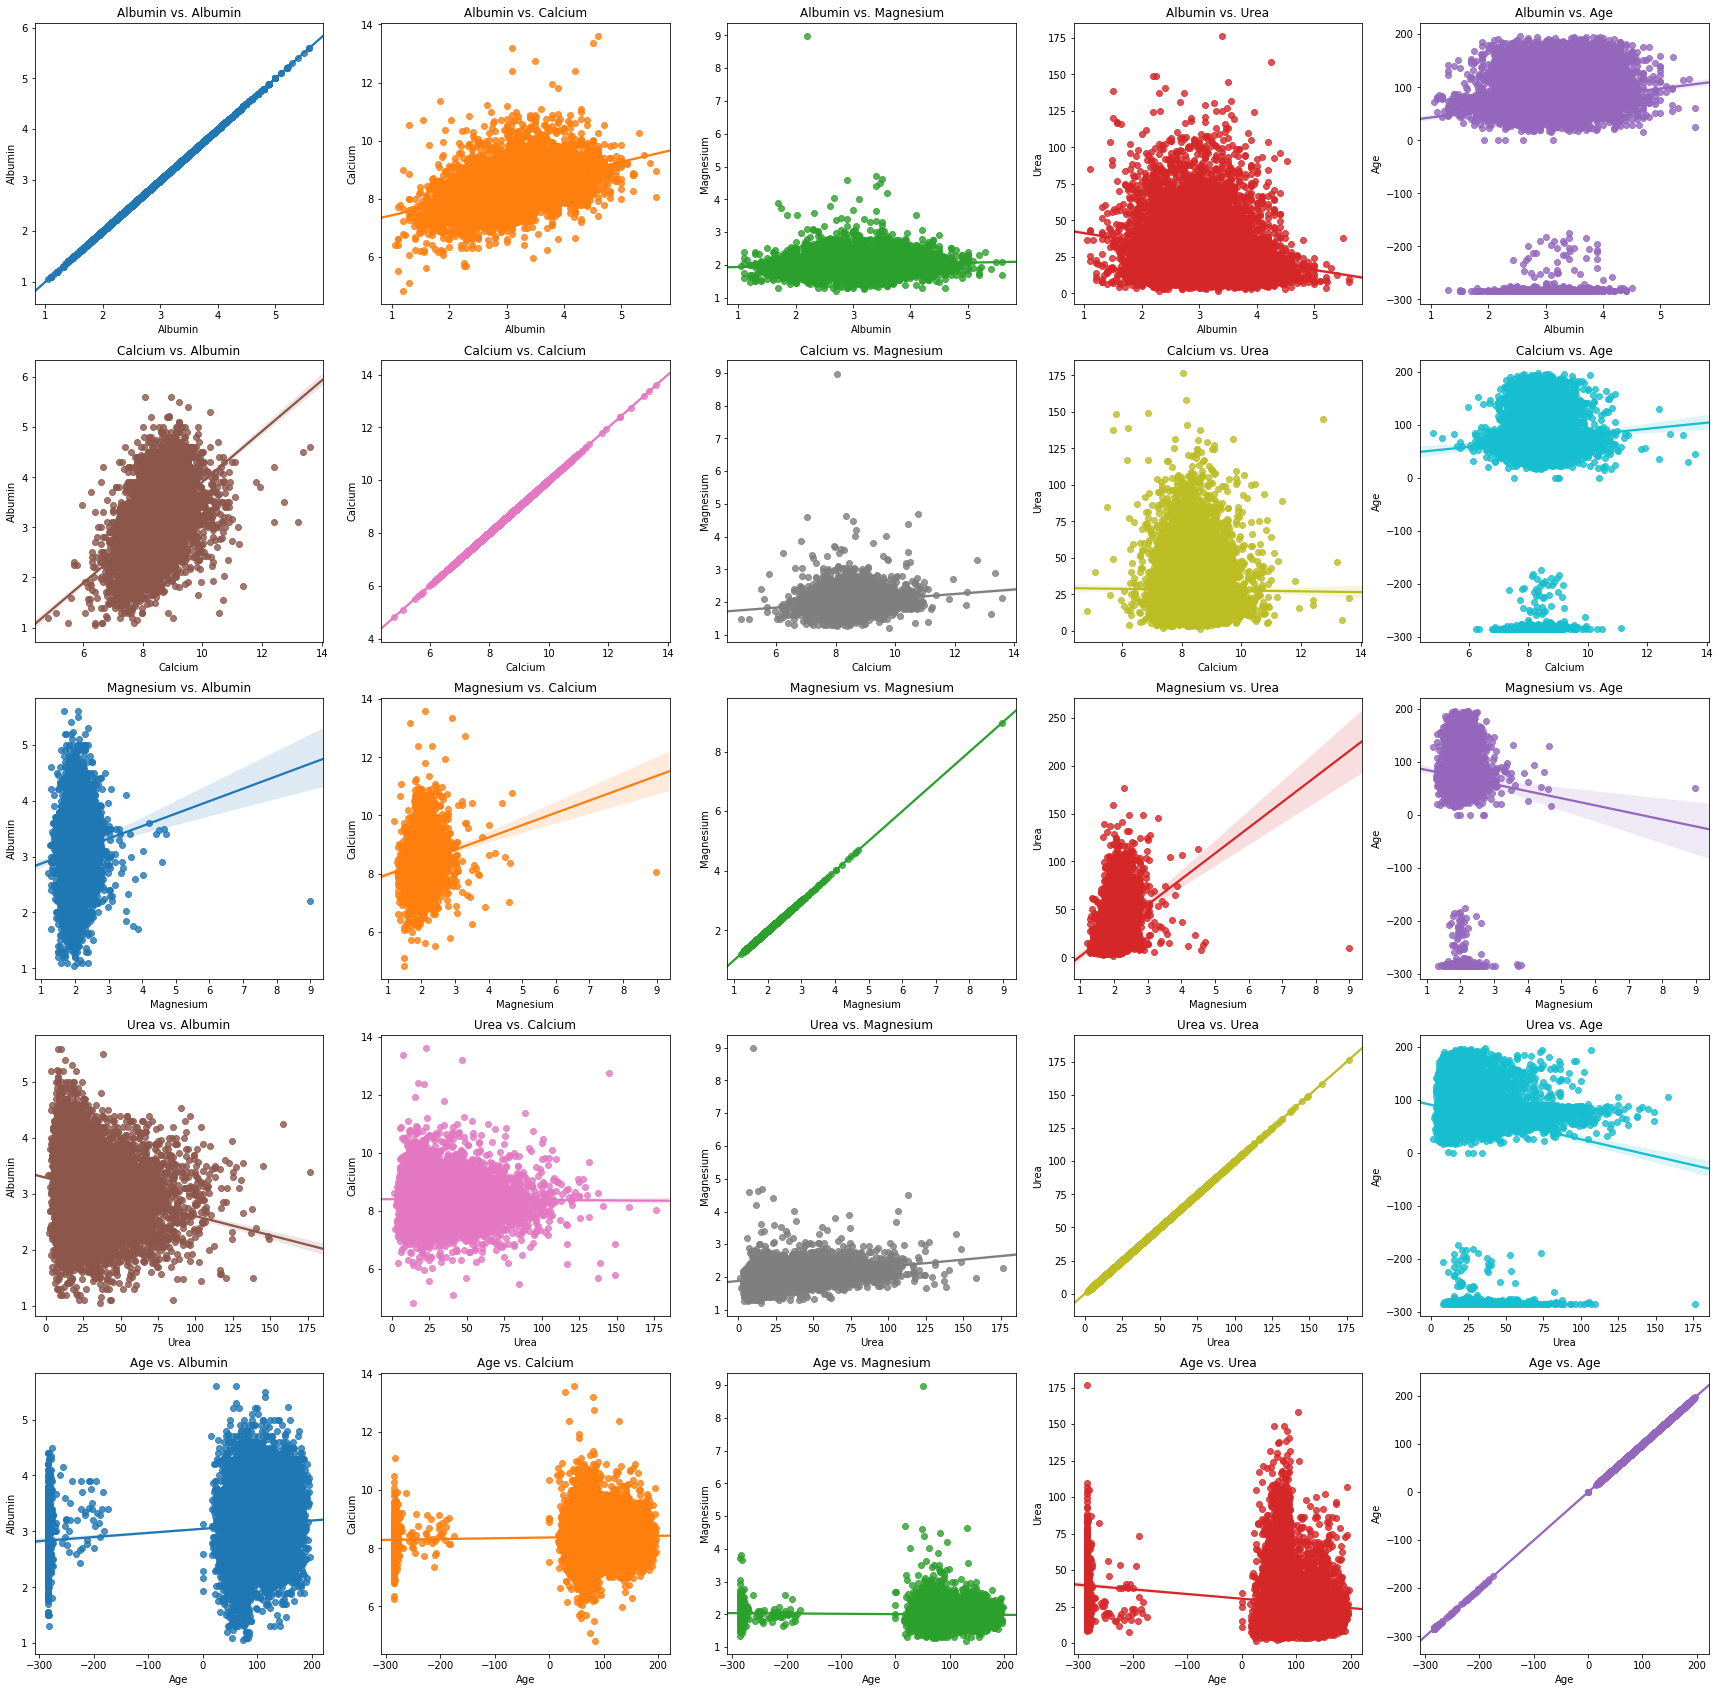

In [53]:
dataCol = ['Albumin', 'Calcium', 'Magnesium', 'Urea', 'Age']
fig, ax = plt.subplots(5,5, sharex=False, sharey=False, figsize=(30,30))

for i in range(5):
    for j in range(5):
        sns.regplot(x=dataCol[i], y=dataCol[j], data=predictor,  ax=ax[i,j])
        ax[i,j].set_title(dataCol[i] + ' vs. ' + dataCol[j])
        ax[i,j].set_xlabel(dataCol[i])
        ax[i,j].set_ylabel(dataCol[j])